# Prototype of the Inclinet model

To generate a basic prototype, we reduced the size of 512x512 images to 64x64.
Only RGB images are used in this model, and the semi-major axes of galaxies are alligned horizantally to the best of our knowledge. 


## Importing Packages

In [2]:
import sys
import os
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import scipy.misc as scimisc
import random

# from google.colab import drive
# drive.mount('/content/drive')

## Loading the data

Data has been stored in compressed numpy format. 
More details and the data preprocessing process is presented in this notebook: https://github.com/ekourkchi/incNET-data/blob/master/incNET_dataPrep/Data_Preparation.ipynb


All galaxies are aligned to have their semi-major axes aligned horizontally.

In [3]:
data = np.load('/content/drive/My Drive/Colab Notebooks/data_64x64.npz')
images_ = data['images'].astype(np.uint8)
labels_ = data['labels'] 
data.close() 

### Looking at an example image

inclination: 51 degree


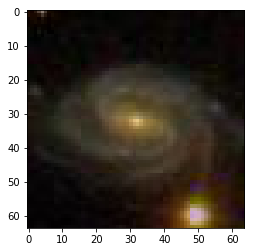

In [4]:
i = 750
print("inclination: {} degree".format(labels_[1][i]))
plt.imshow(images_[i])

### Data Preparation

In this model we are interested in galaxies with inclinations no more than 45 degrees from face-on. 
We set aside 10% of data for the evaluation purpose. 

The preprocessed data has been already augmented by images that are simply the mirrored version of the original images. In the following block, we make sure that none of the mirrored images of the training sample contaminate the test sample.

In [5]:
from sklearn.model_selection import train_test_split

ix, = np.where(labels_[1]>=45)

images_c = images_[ix]
labels_c = labels_[1][ix]
pgcIDs_c = labels_[0][ix]

images_train, images_test, labels_train, labels_test, pgcIDs_train,  pgcIDs_test = train_test_split(images_c, labels_c, pgcIDs_c, test_size=0.40)

notUnique = np.isin(pgcIDs_test, pgcIDs_train)
Unique = np.logical_not(notUnique)

images_train = np.concatenate((images_train, images_test[notUnique]))
labels_train  = np.concatenate((labels_train, labels_test[notUnique]))
pgcIDs_train = np.concatenate((pgcIDs_train, pgcIDs_test[notUnique]))

images_test = images_test[Unique]
labels_test = labels_test[Unique]
pgcIDs_test = pgcIDs_test[Unique]


### Checking the shape of the Training and Testing data

- **Size of Training Sample:** ~43,000

- **Size of the Testing Sample:** ~10,000

In [6]:
print(images_train.shape)
print(images_test.shape)
print(labels_train.shape)
print(labels_test.shape)
print(pgcIDs_train.shape)
print(pgcIDs_test.shape)

(43072, 64, 64, 3)
(1148, 64, 64, 3)
(43072,)
(1148,)
(43072,)
(1148,)


### Exploring the distribution of galaxy inclinations in our sample

As seen, the label distribution is non-uniform. This effect arrise from the sample selection criteria for another research where more edge on galaxies were preferred.

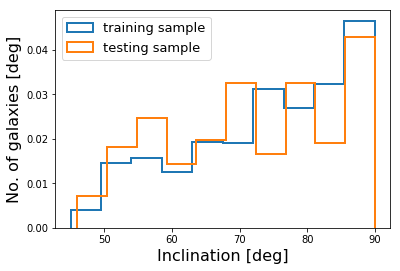

In [7]:
plt.hist(labels_train, histtype='step', label='training sample', density=True, linewidth=2)
plt.hist(labels_test, histtype='step', label='testing sample', density=True, linewidth=2)

plt.xlabel("Inclination [deg]", fontsize=16)
plt.ylabel("No. of galaxies [deg]", fontsize=16)

plt.legend(loc=2, fontsize=13)

### Defining the CNN model

Here, the number of layers and the size of convolutional filters have been changed manually in a try-and-error process to get a reasonable performance. 

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import numpy as np

def vgg(input_shape=(64, 64, 3), n_labels=None, useTanh=False):

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25))

    ## Fully connected layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_2'))
    model.add(tf.keras.layers.Dense(32, activation='relu', name='fc_4'))
    model.add(tf.keras.layers.Dense(8, activation='relu', name='fc_5'))

    # output layer
    if not useTanh:
      if n_labels is None:
        model.add(tf.keras.layers.Dense(1, name='fc_out1'))
      else:
        model.add(tf.keras.layers.Dense(n_labels, activation='softmax'))
    else:
        model.add(tf.keras.layers.Dense(1, activation="tanh", name='fc_out1'))

    return model

Instantiating the model training. 

**Notes:** There is a hint that reducing the batch size improves the results and prevents over-fitting

- batch size: 128
- shuffle: True (to make sure the sample is reshuffled at each epoch)
- optimizer: Adam (Adaptive Moment Estimation)
- metrics:
  - *mae:* mean absolute error
  - *rmse:* root mean squared error

  Custom loss has not used in the end. It's been generated for the purpose of the evaluation of a few customized loss functions

In [9]:
import keras.backend as K

# defining a customized loss function
# def custom_loss(y_true, y_pred):

#     yt = K.cast(y_true, dtype='float64')
#     yp = K.cast(y_pred, dtype='float64')
#     # mask = K.less(y_true, 70) 
#     loss = K.square(yt - yp) / K.abs(91.-yt)
#     loss = K.mean(loss, -1)  
#     # mse = K.sqrt(loss)
#     # return 0.25 * mask * mse + mse
#     return  K.sqrt(loss)

vgg_model = vgg()
vgg_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae'])
n_epochs=50
vgg_model.summary()
vgg_model_history = vgg_model.fit(images_train/255., labels_train, 
                                  epochs=n_epochs, batch_size=128, 
                                  validation_data=(images_test/255., labels_test),
                                  verbose=1, shuffle=True)

Using TensorFlow backend.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 62, 62, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 28, 28, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 26, 26, 32)        9248      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 26, 26, 32)        1

## Plotting the evaluation metrics

Here, we plot how the loss function converges as the training process proceeds. 

**Left:** Loss function vs. the Epoch number

**Right:** Evaluation metrics (rms, rmse) vs. the Epoch number

The training process can be continued until the evaluation metrics are not getting better (or even getting worse) while the same metrics on the training sample are still improving or remaining unchanged. 
Since, we are in the prototyping phase in this notebook, we avoid to over-train the model for the purpose of saving time and testing out different model configurations.

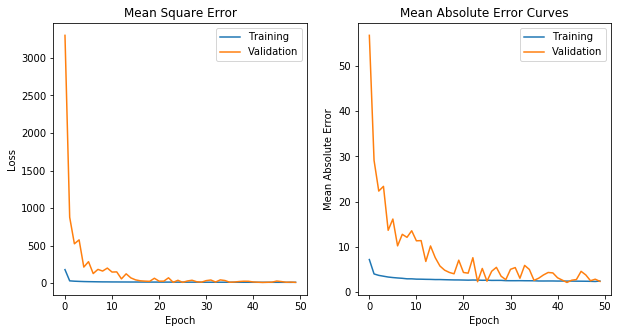

In [10]:
def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['mae']
    val_acc = history.history['val_mae']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation')
    ax[0].set_title('Mean Square Error')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation')
    ax[1].set_title('Mean Absolute Error Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Absolute Error')
    
# plot the training history
plot_model_history(vgg_model.history)
  

## Saving the model
Storing the model weight numbers
In order to use the model for later deployment we store the entire trained network.

In [11]:
vgg_model.save("/content/drive/My Drive/CNN_inc_VGG_regr.h5")
print("Mode is saved on the disk ...")

Mode is saved on the disk ...


## Model Evaluation

Now, we apply the trained model on the test data to evaluate its performance. 

In [12]:
inc_p = vgg_model.predict(images_test/255.)
inc_m = labels_test

N = images_test.shape[0]
inc_p = inc_p.reshape(N)

## An example of evaluated inclination

Predicted:  67.31271
Measured:  67


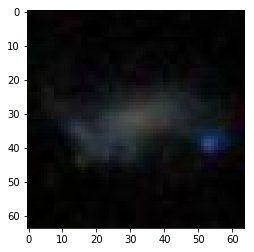

In [13]:
i = 230

print "Predicted: ", inc_p[i]
print "Measured: ", inc_m[i]
plt.imshow(images_test[i])

## Predictions vs. Actual measurements

We cross compare the evaluated inclinations versus the actual labels. 

To get better understanding of the model performance, we plot the difference between the evaluated inclinations and the measured values by users ($\Delta i-i_m-i_p$). In the following plot, the horizontal axis shows the measured inclinations. Each point represents a galaxy in the test sample. 

- **Left Panel:** Predicted values $i_p$, are directly generated by applying the trained network on the test sample. Red sold line displays the results of a least square linear fit on the blue points. Evidently, there is a inclination dependent bias that is inclination dependent. This bias has been linearly modeled by the red line, which is utilized to adjust the predicted values. The slope and intercept of the fitted line are encoded in the $m$ and $b$ parameters.
- **Right Panel:** Same as the left panel, with adjusted predictions, $i_{pc}$, that is calculated using $i_{pc}= \frac{i_p+b}{1-m}$.

**Note: ** The root mean square of the prediction$-$measurements differences is $~3^o$. The similar metric is $~2.6^o$ when we compare the measured values of two groups of the human users. This means our model is slightly performs worst than human, and most of that poor performances is attributed to the outliers and features (like data noise, point sources, stellar spikes, poor images, etc.) without enough data coverage.

Raw RMS: 3.10 deg
Adjusted RMS: 2.93 deg


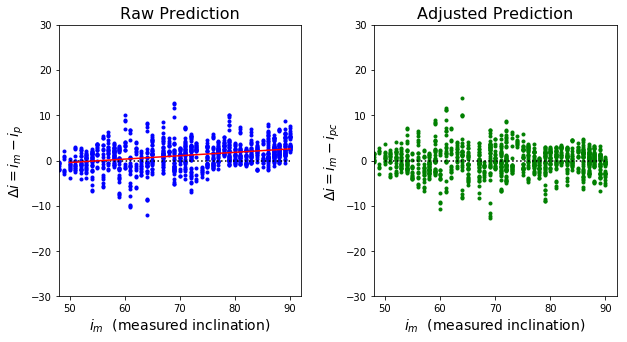

In [14]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

d = inc_m-inc_p

m, b = np.polyfit(inc_m, d, 1)
x = np.linspace(50,90,20)
y  = m*x+b

ax[0].plot(inc_m, d, 'b.')
ax[0].plot([50,90],[0,0], 'k:')
ax[0].plot(x, y, 'r-')
ax[0].set_xlim(48,92)
ax[0].set_ylim(-30 ,30)
ax[0].set_title('Raw Prediction', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$\Delta i = i_m-i_p$', fontsize=14)

print("Raw RMS: %.2f deg"%np.sqrt(np.mean((d)**2)))

# adjusting the predicted inclinations using the linear model of the bias
inc_pc = (inc_p+b)/(1.-m)
d_ = inc_pc-inc_m

ax[1].plot(inc_m, d_, 'g.')
ax[1].plot([50,90],[0,0], 'k:')
ax[1].set_xlim(48,92)
ax[1].set_ylim(-30,30)

print("Adjusted RMS: %.2f deg"%np.sqrt(np.mean((d_)**2)))
ax[1].set_title('Adjusted Prediction', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$\Delta i = i_m-i_{pc}$', fontsize=14)

plt.subplots_adjust( wspace=0.3)

### Plotting the predicted values against the true labels

The dashed line displays where both parameters are equal. The color code is the same as that in the above figure, i.e. blue for raw prediction, green for adjusted values. 

*Note:* Inclinations that are larger than $90^o$ are unacceptable and should be replaced by $90^o$ in production. 

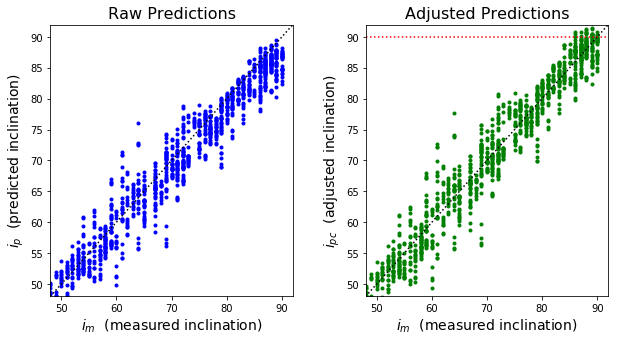

In [15]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

ax[0].plot(inc_m, inc_p, 'b.')
ax[0].plot([48,92],[48,92], 'k:')
ax[0].set_xlim(48,92)
ax[0].set_ylim(48,92)
ax[0].set_title('Raw Predictions', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$i_p$'+'  (predicted inclination)', fontsize=14)

ax[1].plot(inc_m, inc_pc, 'g.')
ax[1].plot([48,92],[48,92], 'k:')
ax[1].set_xlim(48,92)
ax[1].set_ylim(48,92)
ax[1].plot([48,92],[90,90], 'r:')
ax[1].set_title('Adjusted Predictions', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$i_{pc}$'+'  (adjusted inclination)', fontsize=14)

plt.subplots_adjust( wspace=0.3)

### Visualizing galaxy images

Here, we show the first 100 galaxy images in the test sample. In each panel, cyan label is the galaxy ID in the *Principal Galaxy  Catalog* (PGC), and green and red labels represent the measured and the raw predicted inclinations. Magenta labels are the predicted inclinations after applying the linear adjustments.

The image of each galaxy and its photoemtry details can be queried using the following URL query

`http://edd.ifa.hawaii.edu/cf4_photometry/get_sdss_cf4.php?pgc=<PGC>`
where `<PGC>` is replaced by the PGC ID of the desired galaxy. 

To determine the inclination of the galaxy in a manual interactive process using *GIZ*, you can follow this URL template
`https://edd.ifa.hawaii.edu/inclination/practice.php?pgc=<PGC>`

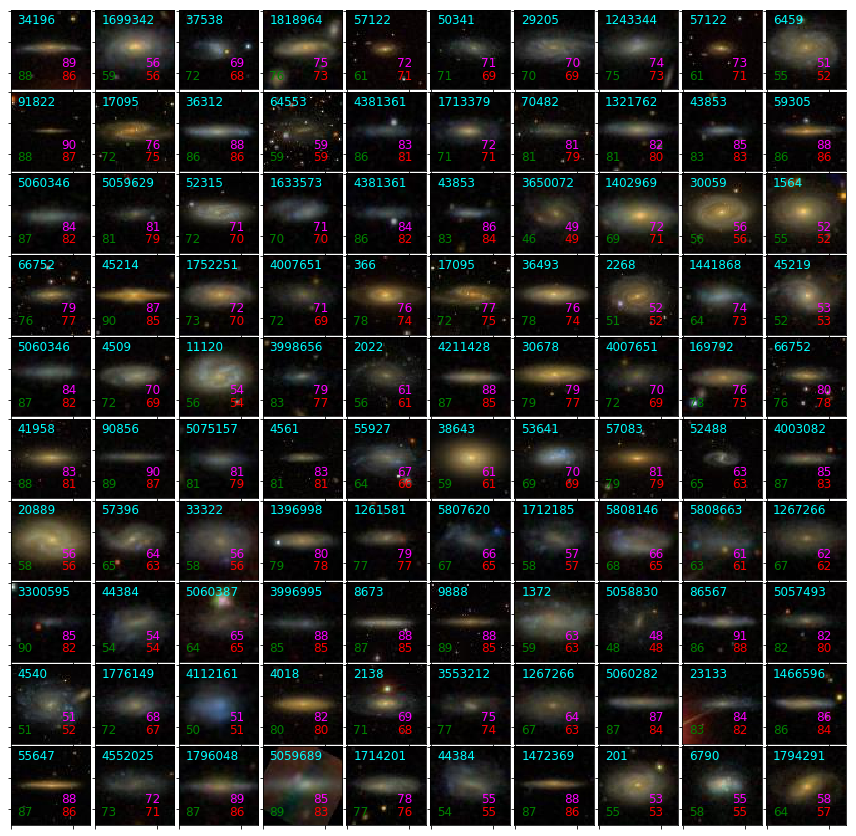

In [16]:
n = 10
m = 10

fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(15,15)) 

t = 0 
for i in range(n):
    for j in range(m):

        ax = axes[i][j]
        ax.imshow(images_test[t,:,:])

        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)

        ax.text(5, 55, inc_m[t], color='green', fontsize=12)
        ax.text(40, 55, "%.0f"%inc_p[t], color='red', fontsize=12)
        ax.text(40, 45, "%.0f"%inc_pc[t], color='magenta', fontsize=12)
        ax.text(5, 10, pgcIDs_test[t], color='cyan', fontsize=12)

        t+=1

plt.subplots_adjust(hspace=0.03, wspace=0.03)

### Examining the Outliers

Here, we try to check out the outliers and see if there is any noticeable similar feature or issues that might cause an issue for the network. We look for noise levels, significant spikes, very bright stars or anything that might have distracted the network from producing the correct answer.

White labels on the top right corner of each panel represent the panel number for better referencing in the text.


* Some cases like PGC1056132 (panels no. 4, 16, 35, 36, 37, 46) are contaminated by a bright star
* Cases similar to PGC42791 (panels no.  18, 26, 28, 40) have poor colorful images. 
* Panels like PGC72528 (no. 34) present good quality images of galaxies, but the model fails to determine their inclinations precisely. This can further assess by either implementing more complicated network or training the same model with more iterations.


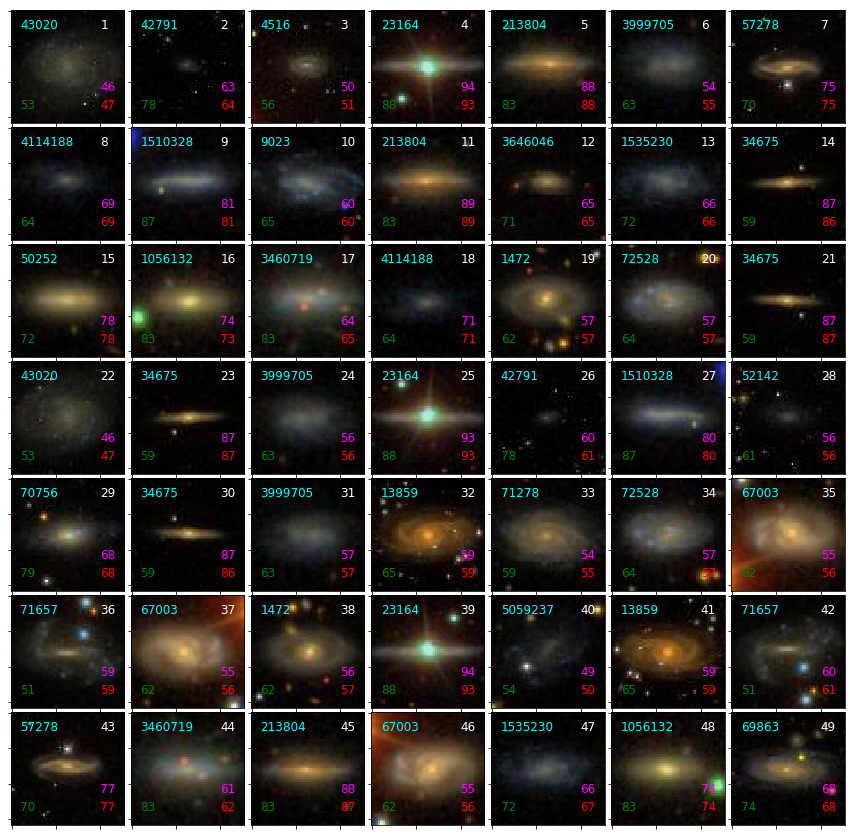

In [ ]:
n = 7
m = 7

fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(15,15)) 

t = 0 
ii = 1
delta = np.abs(inc_m[t]-inc_pc[t])
for i in range(n):
    for j in range(m):
        
        while t<len(inc_m) and delta < 5:
          t += 1
          delta = np.abs(inc_m[t]-inc_pc[t])
        ax = axes[i][j]
        ax.imshow(images_test[t,:,:])

        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)

        ax.text(5, 55, inc_m[t], color='green', fontsize=12)
        ax.text(50, 10, ii, color='white', fontsize=12); ii+=1
        ax.text(50, 55, "%.0f"%inc_p[t], color='red', fontsize=12)
        ax.text(50, 45, "%.0f"%inc_pc[t], color='magenta', fontsize=12)
        ax.text(5, 10, pgcIDs_test[t], color='cyan', fontsize=12)

        t+=1
        delta = np.abs(inc_m[t]-inc_pc[t])

plt.subplots_adjust(hspace=0.03, wspace=0.03)

# **Tanh** in the last layer

The fact that our galaxy labels lie in the 40-90 degree range is a good motivation for us to use *Tanh* in the last layer to force the network to generate values within the specified range.

In the following cells we change the activation function of the last layer to *Tanh* and normalize images by dividing them by 255.

The target labels should range between -1 and 1 and are derived from the inclinations as 

$New~Label = 2(i-45)/45 - 1$.

In [ ]:
vgg_model = vgg(useTanh=True)
vgg_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae'])
n_epochs = 50
vgg_model.summary()

vgg_model_history = vgg_model.fit(images_train, 2.*(labels_train-45.)/45. - 1., 
                                  epochs=n_epochs, batch_size=64, 
                                  validation_data=(images_test, 2.*(labels_test-45.)/45. - 1.),
                                  verbose=1, shuffle=True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 62, 62, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 30, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 28, 28, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 26, 26, 32)        9248      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 26, 26, 32)       

### Plotting the evaluations metrics

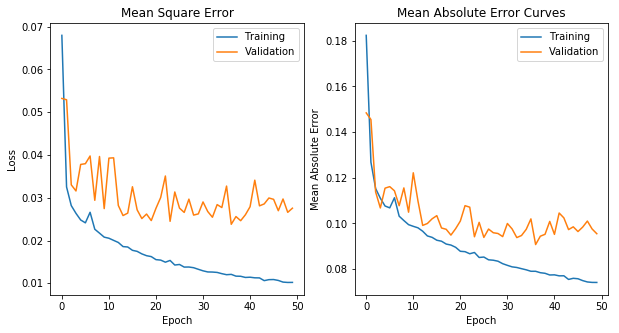

In [ ]:
def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['mae']
    val_acc = history.history['val_mae']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation')
    ax[0].set_title('Mean Square Error')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation')
    ax[1].set_title('Mean Absolute Error Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Absolute Error')
    
# plot the training history
plot_model_history(vgg_model.history)

In [ ]:
inc_p = 0.5*((vgg_model.predict(images_test)+1.)*45.)+45.
inc_m = labels_test

N = images_test.shape[0]
inc_p = inc_p.reshape(N)

## Evaluating the performance of the new network

Evidently, leveraging the *Tanh* activation function in the last layer doesn't necessarily remedy the prediction bias.

Raw RMS: 3.73 deg
Adjusted RMS: 3.93 deg


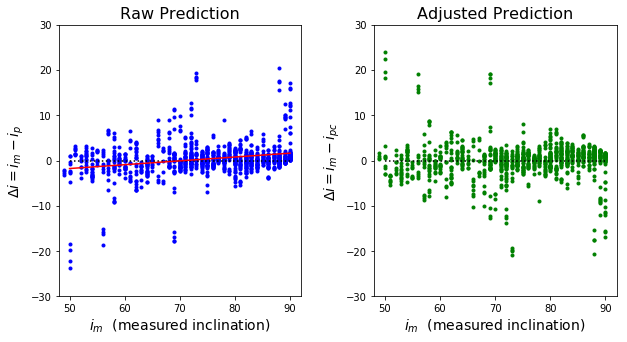

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

d = inc_m-inc_p

m, b = np.polyfit(inc_m, d, 1)
x = np.linspace(50,90,20)
y  = m*x+b

ax[0].plot(inc_m, d, 'b.')
ax[0].plot([50,90],[0,0], 'k:')
ax[0].plot(x, y, 'r-')
ax[0].set_xlim(48,92)
ax[0].set_ylim(-30 ,30)
ax[0].set_title('Raw Prediction', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$\Delta i = i_m-i_p$', fontsize=14)

print("Raw RMS: %.2f deg"%np.sqrt(np.mean((d)**2)))

# adjusting the predicted inclinations using the linear model of the bias
inc_pc = (inc_p+b)/(1.-m)
d_ = inc_pc-inc_m

ax[1].plot(inc_m, d_, 'g.')
ax[1].plot([50,90],[0,0], 'k:')
ax[1].set_xlim(48,92)
ax[1].set_ylim(-30,30)

print("Adjusted RMS: %.2f deg"%np.sqrt(np.mean((d_)**2)))
ax[1].set_title('Adjusted Prediction', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$\Delta i = i_m-i_{pc}$', fontsize=14)

plt.subplots_adjust( wspace=0.3)

### Examining the Outliers

As explained above, most outliers belong to poor quality images, or galaxies with a bright star in the field. 

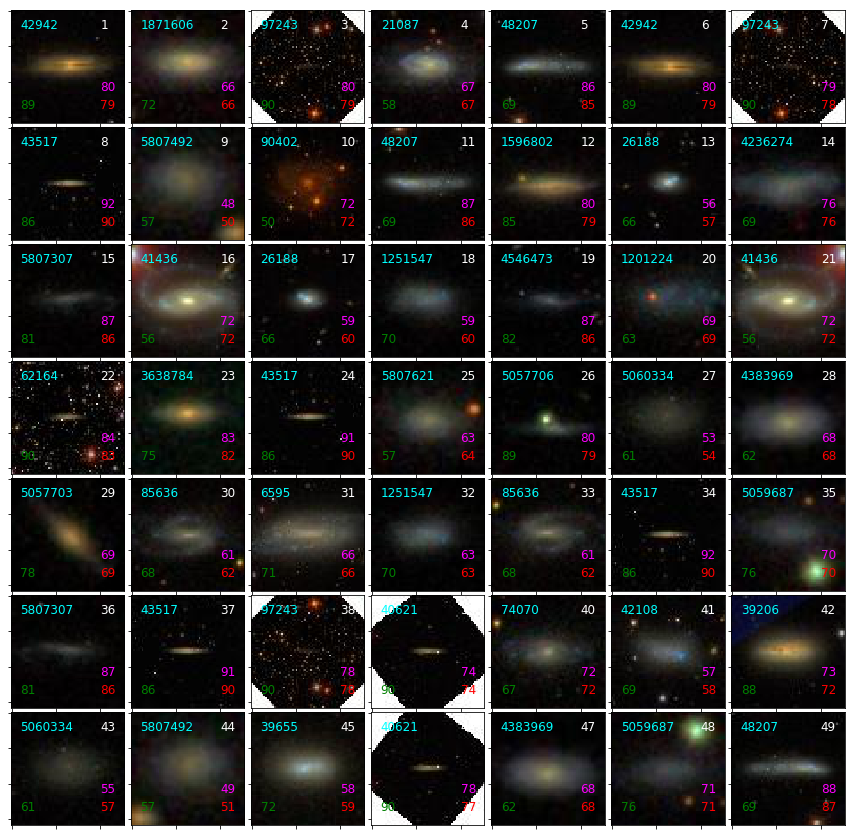

In [ ]:
n = 7
m = 7

fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(15,15)) 

t = 0 
ii = 1
delta = np.abs(inc_m[t]-inc_pc[t])
for i in range(n):
    for j in range(m):
        
        while t<len(inc_m) and delta < 5:
          t += 1
          delta = np.abs(inc_m[t]-inc_pc[t])
        ax = axes[i][j]
        ax.imshow(images_test[t,:,:])

        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)

        ax.text(5, 55, inc_m[t], color='green', fontsize=12)
        ax.text(50, 10, ii, color='white', fontsize=12); ii+=1
        ax.text(50, 55, "%.0f"%inc_p[t], color='red', fontsize=12)
        ax.text(50, 45, "%.0f"%inc_pc[t], color='magenta', fontsize=12)
        ax.text(5, 10, pgcIDs_test[t], color='cyan', fontsize=12)

        t+=1
        delta = np.abs(inc_m[t]-inc_pc[t])

plt.subplots_adjust(hspace=0.03, wspace=0.03)

# Sample distribution

Below, we attempt to generate a sample with uniform distribution of labels. This allows us to explore the effect of the uniformity of the measure inclinations.


### Reading the data from disk


In [ ]:
data = np.load('/content/drive/My Drive/Colab Notebooks/data_64x64.npz')
images_ = data['images']
labels_ = data['labels'] 
data.close() 

ix, = np.where(labels_[1]>=45)

images_c = images_[ix]
labels_c = labels_[1][ix]
pgcIDs_c = labels_[0][ix]

### Generating a uniform sample

To generate a unifrom inclination, we randomly draw 5000 galaxies from intervals of size 5 degrees aparats to cover the entire range of 45 to 90 degrees.

In [ ]:
## Shuffling  the sample to generate a fair sample
def shuffle(array, seed=0):
        random.seed(seed)
        random.shuffle(array)
        return array

n = len(labels_c)

indices = np.arange(n)
s_idx = None
for i in range(45,90,5):

  if i!=85:
    idx = indices[((labels_c>=i)&(labels_c<i+5))]
  else:
    idx = indices[((labels_c>=i)&(labels_c<=i+5))]
  idx = shuffle(idx, seed=i+200)
  idx = np.random.choice(idx, 5000)

  # unique_IDs = []
  # unique_inx = []

  # for i, id in enumerate(pgcIDs_c[idx]):
  #     if not id in unique_IDs:
  #         unique_inx.append(i)
  #         unique_IDs.append(id)

  # idx = idx[unique_inx][:1000]

  if s_idx is None:
    s_idx = idx
  else:
    s_idx = np.concatenate((s_idx, idx))
  
  print(len(idx))
  

5000
5000
5000
5000
5000
5000
5000
5000
5000


## Visualizing the histogram of the inclinations

**Red:** The distribution of the inclination of the original sample

**Black** The distribution of the uniformed ensemble

In [ ]:
import copy
labels_c_orig = copy.deepcopy(labels_c)
images_c = images_c[s_idx]
labels_c = labels_c[s_idx]
pgcIDs_c = pgcIDs_c[s_idx]

images_train, images_test, labels_train, labels_test, pgcIDs_train,  pgcIDs_test = train_test_split(images_c, labels_c, pgcIDs_c, test_size=0.40)

notUnique = np.isin(pgcIDs_test, pgcIDs_train)
Unique = np.logical_not(notUnique)

images_train = np.concatenate((images_train, images_test[notUnique]))
labels_train  = np.concatenate((labels_train, labels_test[notUnique]))
pgcIDs_train = np.concatenate((pgcIDs_train, pgcIDs_test[notUnique]))

images_test = images_test[Unique]
labels_test = labels_test[Unique]
pgcIDs_test = pgcIDs_test[Unique]

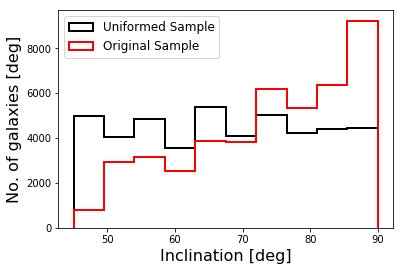

In [ ]:
plt.hist(labels_c, histtype='step', label='Uniformed Sample', density=False, color='k', linewidth=2)
plt.hist(labels_c_orig, histtype='step', label='Original Sample', density=False, color='red', linewidth=2)

plt.xlabel("Inclination [deg]", fontsize=16)
plt.ylabel("No. of galaxies [deg]", fontsize=16)

plt.legend(loc=2, fontsize=12)

We keep the `Tanh` layer and continue to normalize images since there is hint of a faster convergence. 

In [ ]:
vgg_model = vgg(useTanh=True)
vgg_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae'])
n_epochs=50
vgg_model.summary()

vgg_model_history = vgg_model.fit(images_train, 2.*(labels_train-45.)/45. - 1., 
                                  epochs=n_epochs, batch_size=64, 
                                  validation_data=(images_test, 2.*(labels_test-45.)/45. - 1.),
                                  verbose=1, shuffle=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 62, 62, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 30, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 28, 28, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 26, 26, 32)        9248      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 26, 26, 32)       

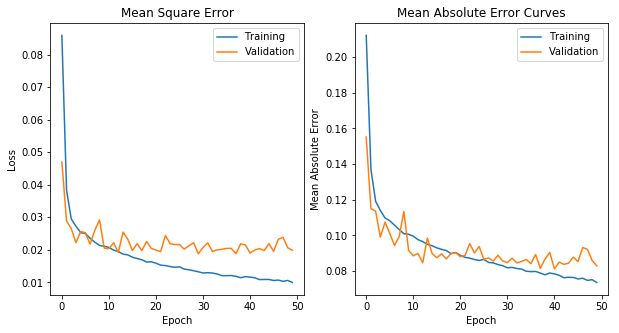

In [ ]:
def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['mae']
    val_acc = history.history['val_mae']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation')
    ax[0].set_title('Mean Square Error')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation')
    ax[1].set_title('Mean Absolute Error Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Absolute Error')
    
# plot the training history
plot_model_history(vgg_model.history)

In [ ]:
inc_p = 0.5*((vgg_model.predict(images_test)+1.)*45.)+45.
inc_m = labels_test

N = images_test.shape[0]
inc_p = inc_p.reshape(N)

## Is the slanted trend gone?

No. No matter how hard we try to flatten the trend, this might not go away completely. This might have originated from the method network is trained. At larger inclinations, we are dealing with a network that has been trained mostly by galaxies with lower inclinations, Therefore the network tend to produce smaller values.
On the other hand, at lower inclinations we are making predictions based on a network that has mostly seen galaxies with larger inclinations. Only at the center of the distribution there is a balance between low and high values. 

Raw RMS: 3.17 deg
Adjusted RMS: 3.26 deg


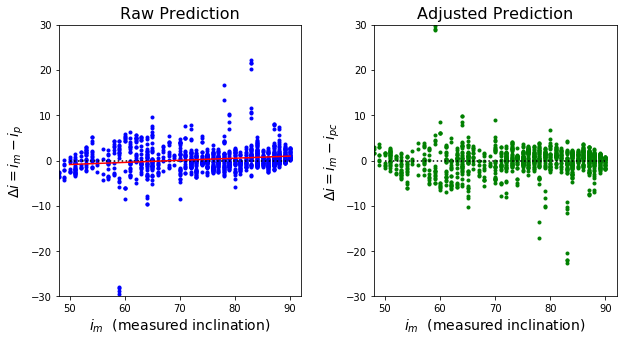

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

d = inc_m-inc_p

m, b = np.polyfit(inc_m, d, 1)
x = np.linspace(50,90,20)
y  = m*x+b

ax[0].plot(inc_m, d, 'b.')
ax[0].plot([50,90],[0,0], 'k:')
ax[0].plot(x, y, 'r-')
ax[0].set_xlim(48,92)
ax[0].set_ylim(-30 ,30)
ax[0].set_title('Raw Prediction', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$\Delta i = i_m-i_p$', fontsize=14)

print("Raw RMS: %.2f deg"%np.sqrt(np.mean((d)**2)))

# adjusting the predicted inclinations using the linear model of the bias
inc_pc = (inc_p+b)/(1.-m)
d_ = inc_pc-inc_m

ax[1].plot(inc_m, d_, 'g.')
ax[1].plot([50,90],[0,0], 'k:')
ax[1].set_xlim(48,92)
ax[1].set_ylim(-30,30)

print("Adjusted RMS: %.2f deg"%np.sqrt(np.mean((d_)**2)))
ax[1].set_title('Adjusted Prediction', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$\Delta i = i_m-i_{pc}$', fontsize=14)

plt.subplots_adjust( wspace=0.3)

## Visualizing the outliers

Similar to what we presented above, the common pitfalls and artificial can be found in the images. Maybe, making more complicated networks help we mitigate the problem. Moreover, introducing more galaxies (real or synthetic) to the sample helps improve the training process and make better predictions. 

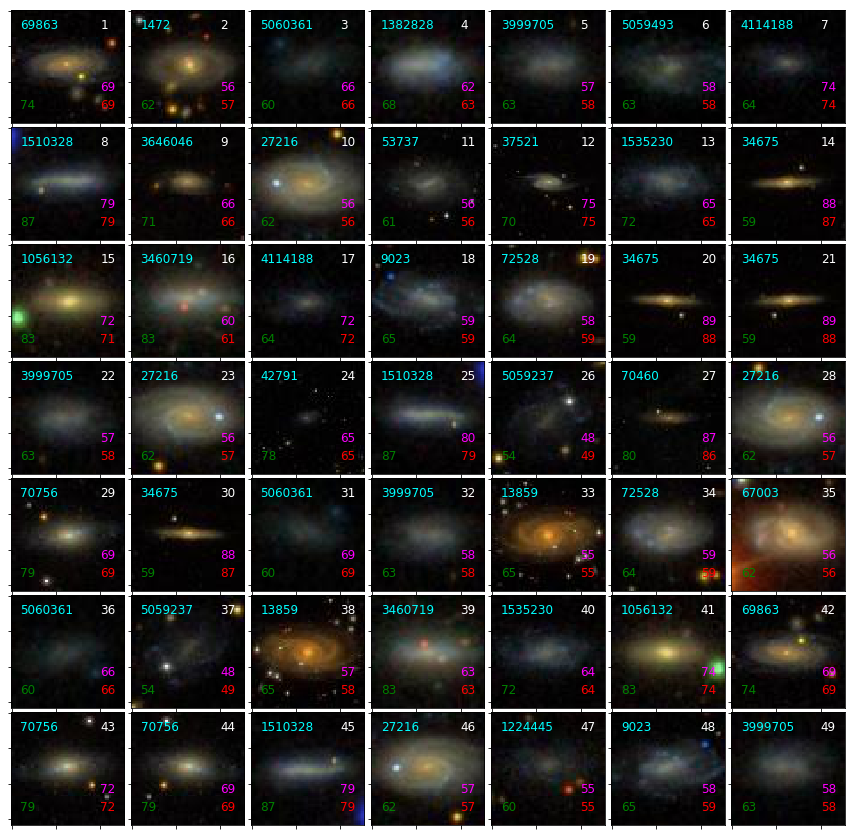

In [ ]:
n = 7
m = 7

fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(15,15)) 

t = 0 
ii = 1
delta = np.abs(inc_m[t]-inc_pc[t])
for i in range(n):
    for j in range(m):
        
        while t<len(inc_m) and delta < 5:
          t += 1
          delta = np.abs(inc_m[t]-inc_pc[t])
        ax = axes[i][j]
        ax.imshow(images_test[t,:,:])

        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)

        ax.text(5, 55, inc_m[t], color='green', fontsize=12)
        ax.text(50, 10, ii, color='white', fontsize=12); ii+=1
        ax.text(50, 55, "%.0f"%inc_p[t], color='red', fontsize=12)
        ax.text(50, 45, "%.0f"%inc_pc[t], color='magenta', fontsize=12)
        ax.text(5, 10, pgcIDs_test[t], color='cyan', fontsize=12)

        t+=1
        delta = np.abs(inc_m[t]-inc_pc[t])

plt.subplots_adjust(hspace=0.03, wspace=0.03)

## Summary

In this notebook, we trained three different models, all of which treat the problem as a regression problem. 

[](In another notebook), we explore the possibility of getting similar (or slightly) better results by invoking the classification techniques, and loss functions. 


*   A basic CNN using the original sample of 64x64 images. We found out that the distribution of labels (inclinations) is not uniform. The last layer of the network is activated with a *Relu* function. It turned our that the measured in predicted values are in good agreement, however an inclination dependent bias is evident. We attributed to the non-uniformity of inclinations and the fact that inclinations span a finite range of number between 45 and 90 degrees.
*   We modified the CNN by changing the activation of the last layer to *Tanh*. We normalized images and linearly adjusted inclination to be compatible with the *Tanh* output ranging from -1 to 1. The bias is still evident, but the convergence is reached more quickly. Further tests seems to be necessary to make a concrete conclusion here. 
*   We train the same CNN with *Tanh* output layer, but the training sample has been modified to has a uniform distribution of labels. We observe a better performance of the network, and the prediction-measurement bias has become smaller and less significant. 

**Further Notes: ** Using smaller batch sizes and training the model with more iterations help to minimize the bias. However part of the bias that originates from the finite coverage of the inclinations cannot be removed completely. 



